[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/laxman-22/Interpretable-ML/blob/main/interpretable_ml.ipynb)

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score
from pygam import LinearGAM, s

## Exploratory Data Analysis

First we can take a look at the raw data in pandas. This dataset comes from Kaggle and can be found here: https://www.kaggle.com/datasets/blastchar/telco-customer-churn?resource=download.

The models are from scikit-learn for linear and logistic regression and pygam for the GAM model.

In [2]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
pd.set_option('display.max_columns', None)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


My first idea was just to take a look at something obvious which would be to see how long customers stick around with this company

<Axes: xlabel='Churn', ylabel='tenure'>

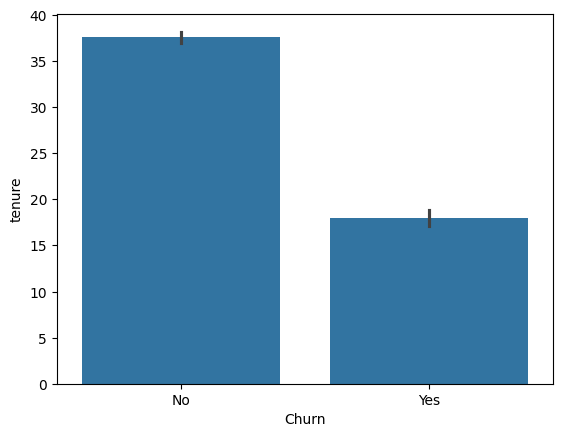

In [3]:
sns.barplot(x='Churn', y='tenure', data=df)

It seems like there is a strong indication that customers who have been with this service provider for a long time tend to not switch providers. We can look into this further with the plot below.

<Axes: xlabel='MonthlyCharges', ylabel='Count'>

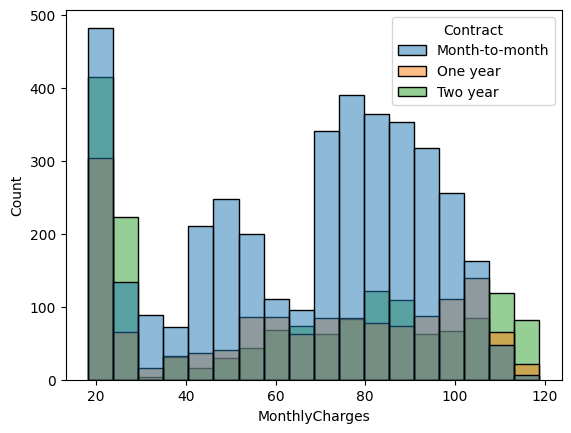

In [4]:
sns.histplot(data=df, x='MonthlyCharges', hue='Contract')

Overall Monthly Charges appear to be on the cheaper side, with two year contracts being the most common by far. This indicates that this company likely doesn't see much Churn risk on the cheaper plans but maybe the issue is in the more expensive plans

<Axes: xlabel='MonthlyCharges', ylabel='Count'>

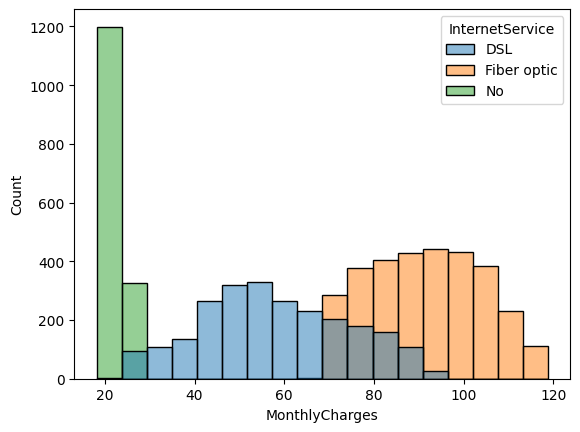

In [5]:
sns.histplot(data=df, x='MonthlyCharges', hue='InternetService')

The more expensive plans appear to have internet service, which may indicate that the internet service is not that good in the company, which can result in higher churn risk.

We can also use a correlation heat map to see if there are any linear relationships in the dataset, but for categorical features, we need to one-hot-encode them to perform correlation calculations. I also chose to select a subset of the features in the initial dataset based on the above analysis.

In [6]:
subset = df[['Churn', 'InternetService',
       'tenure', 'PhoneService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'MonthlyCharges']]
df_encoded = pd.get_dummies(subset, drop_first=True)
correlation = df_encoded.corr()

<Axes: >

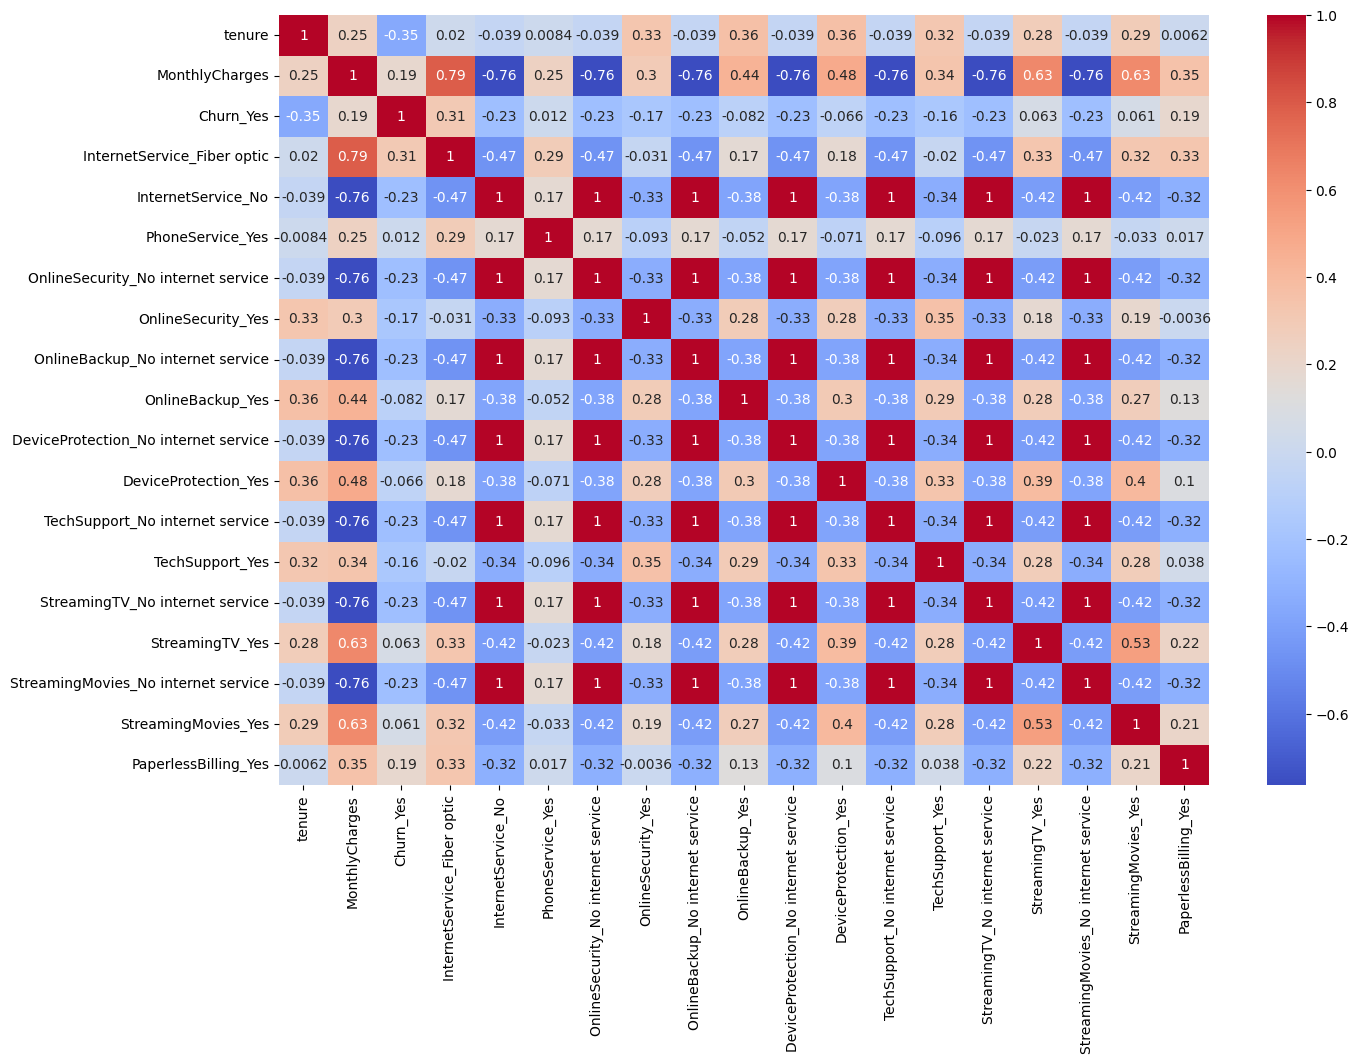

In [7]:
plt.figure(figsize=(15, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

After one hot encoding some categorical columns, there appears to be slightly positive correlations between Churn and Monthly Charges which could indicate that as charges increase monthly, churn rate also increases. There is also a strong positive correlation with InternetService Fiber optic which can indicate poor service for that particular plan, resulting in higher churn rate. This can be confirmed with Linear Regression and Logistic regression. First we can perform Linear Regression

## Linear Regression Implementation and Analysis

The code below was taken from the regression-interpretability.ipynb from the class repo

In [8]:
# Split the dataset into the features and the target data frames
X = df_encoded.drop(columns='Churn_Yes', axis=1)
y = df_encoded['Churn_Yes']

In [9]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# train and evaluate the model
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n{model_name}:")
    print(f"MSE: {mse:.2f}")
    print(f"R2 Score: {r2:.2f}")

    for feature, coef in zip(X.columns, model.coef_):
      print(f"{feature}: {coef:.4f}")

    return model, y_pred
     

# Fit models
lr_model, lr_pred = evaluate_model(LinearRegression(), X_train_scaled, X_test_scaled, y_train, y_test, "Linear Regression")



Linear Regression:
MSE: 0.14
R2 Score: 0.29
tenure: -0.1346
MonthlyCharges: 0.2036
InternetService_Fiber optic: 0.0005
InternetService_No: -0.0007
PhoneService_Yes: -0.0610
OnlineSecurity_No internet service: -0.0007
OnlineSecurity_Yes: -0.0564
OnlineBackup_No internet service: -0.0007
OnlineBackup_Yes: -0.0372
DeviceProtection_No internet service: -0.0007
DeviceProtection_Yes: -0.0294
TechSupport_No internet service: -0.0007
TechSupport_Yes: -0.0566
StreamingTV_No internet service: -0.0007
StreamingTV_Yes: -0.0199
StreamingMovies_No internet service: -0.0007
StreamingMovies_Yes: -0.0100
PaperlessBilling_Yes: 0.0294


The results above show that the linear regression models created aren't that great. The R-squared score is only 0.29 which means only 29% of the variance in the dataset has been captured by the linear regression models. The MSE shows that the error in the models is not that great, which means the models were likely trending in the right direction.

It is also evident that the MonthlyCharges and Churn variables were in fact slightly positively correlated, which is also evident in the coefficient for Monthly charges being slightly positive, indicating an upward trend.

Now we can analyze all the coefficients. The code below was partly taken from the regression-interpretability.ipynb from the class repo

<Figure size 2000x1000 with 0 Axes>

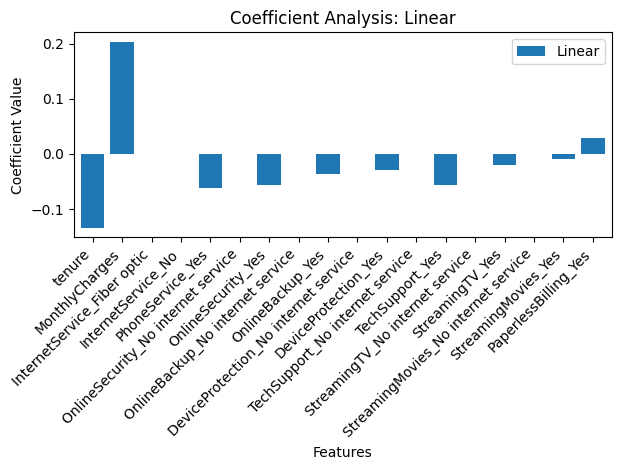

In [10]:
# Coefficient Comparison Plot
def plot_coefficients(lr_model):
    coef_df = pd.DataFrame({
        'Linear': lr_model.coef_
    }, index=X.columns)

    plt.figure(figsize=(20, 10))
    coef_df.plot(kind='bar', width=0.8)
    plt.title('Coefficient Analysis: Linear')
    plt.xlabel('Features')
    plt.ylabel('Coefficient Value')
    plt.legend(loc='best')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_coefficients(lr_model)

The analysis earlier is confirmed with this plot as we can clearly see the slightly positive correlation in the MonthlyCharges feature and the Churn target, which again indicates that as monthly cost increases, the churn rate also increases. 

There are some inversely related features too, such as Tech Support, Device Protection, Online Backup, and Online Security indicating that these are features that are important to customers and results in lower churn rates. However, there is only a slight correlation for these features.

Overall linear regression does show some important relationships but it's not the best model to use as the company needs to classify whether a churn will happen or not.

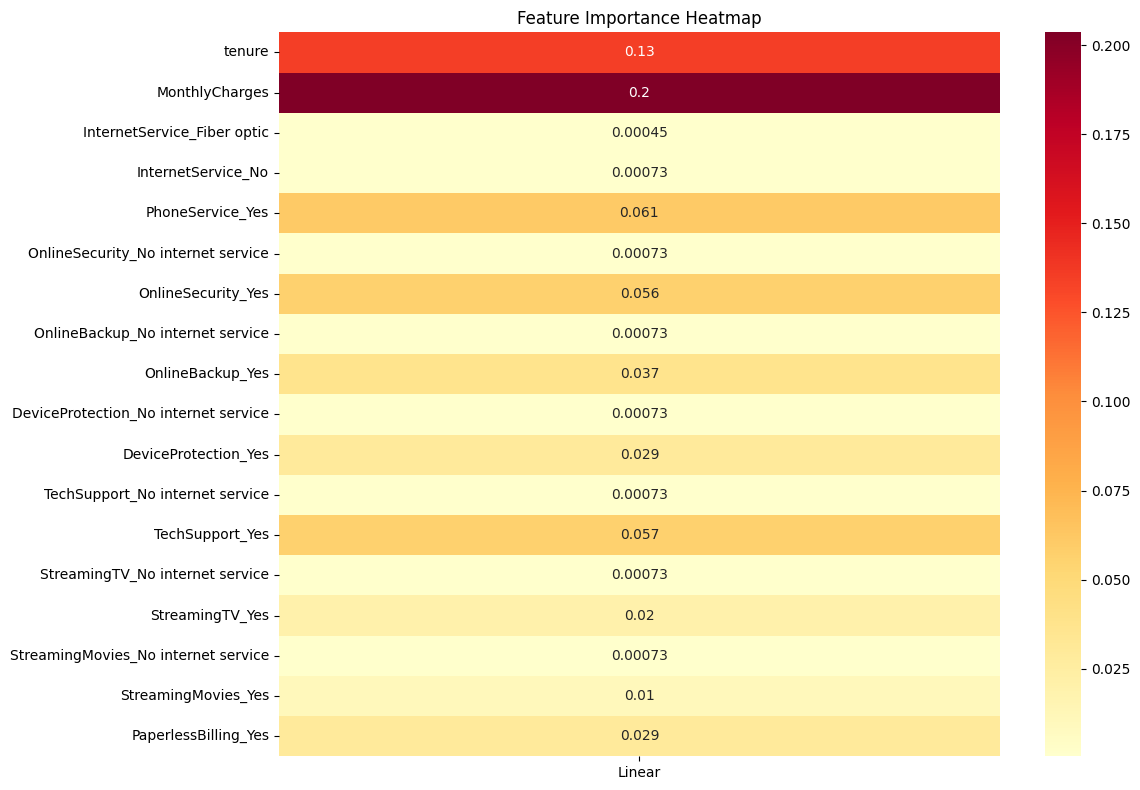

In [11]:
# Feature Importance Heatmap
def plot_feature_importance_heatmap(lr_model):
    importance_df = pd.DataFrame({
        'Linear': np.abs(lr_model.coef_)
    }, index=X.columns)

    plt.figure(figsize=(12, 8))
    sns.heatmap(importance_df, annot=True, cmap='YlOrRd')
    plt.title('Feature Importance Heatmap')
    plt.tight_layout()
    plt.show()

plot_feature_importance_heatmap(lr_model)

The above heat map shows that MonthlyCharges is in fact the most important feature in this dataset along with tenure but it's inversely related.

## Logistic Regression Implementation and Analysis

Below is the implementation and analysis of the Logistic Regression model

In [12]:
# Initialize the Logistic Regression model and train it
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')



Accuracy: 0.81
Precision: 0.69
Recall: 0.55


The accuracy of this model is 81% which is decent as its able to correctly predict almost 80% of the test set correctly. However its not as precise which indicates that the model gets a bit thrown off with variance in the dataset. Also the recall is really low which means that it wasn't able to predict all of the actual Churn data points as Churn, only 55% of the positive predictions were actually predicted correctly which means the model isn't really able to generalize well.

This code was partially generated by ChatGPT

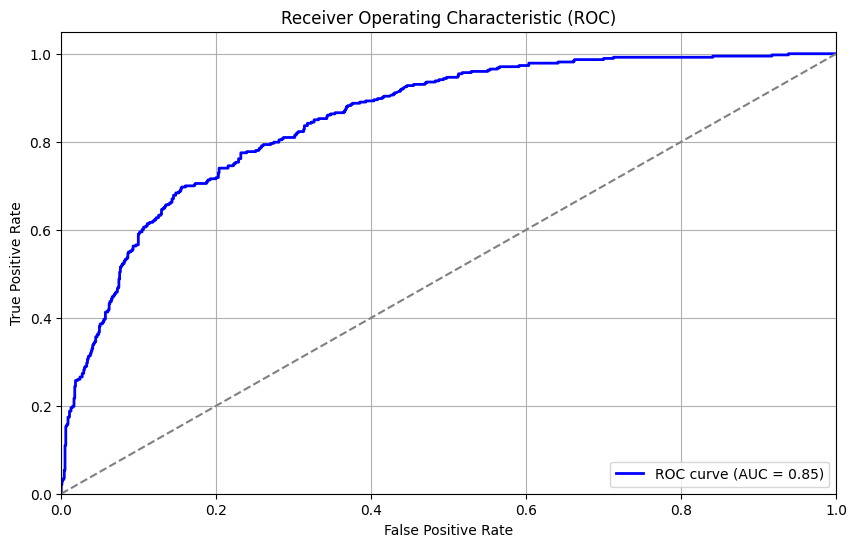

In [13]:
# Calculate necessary values to plot ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Plot ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

The ROC curve shows that the model is relatively good, it's certainly better than the linear regression models as it's sort of able to generalize based on the AUC value. If the model randomly guessed, the ROC curve would lie on the diagonal line, however it performs bettern than random guessing which indicates the model was able to learn important features in the model. Below we can see the coefficients to analyze this further.

<Figure size 2000x1000 with 0 Axes>

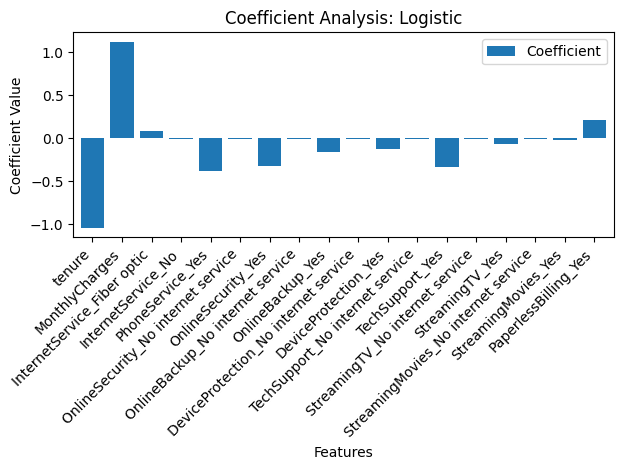

In [14]:
# Retrieve coefficients and features
coefficients = model.coef_[0]
feature_names = X.columns

# Put into dataframe to easily plot
coef_df = pd.DataFrame({
        'Coefficient': coefficients
    }, index=X.columns)

# Plot
plt.figure(figsize=(20, 10))
coef_df.plot(kind='bar', width=0.8)
plt.title('Coefficient Analysis: Logistic')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.legend(loc='best')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

It's clear from the coefficient plot above that the model gave much more importance to the MonthlyCharges feature and tenure compared to all of the others as there was a higher correlation between MonthlyCharges and Churn compared to other features and a negative correlation between tenure and Churn. This also explains why the model had issues in generalizing because it didn't take as many of the other features into account.

## GAM Implementation and Analysis

Below is the GAM implementation and analysis a portion of the code was made using ChatGPT and a portion was also from the generalized-models-interpretability.ipynb file in the class repo

In [15]:
# Initialize GAM model
gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9))

# Find best smoothing parameters for each spline term
gam.gridsearch(X_train_scaled, y_train)

# Fit the model
gam.fit(X_train_scaled, y_train)

# Make predictions
y_pred_gam = gam.predict(X_test_scaled)

# Calculate MSE and R^2
mse_gam = mean_squared_error(y_test, y_pred_gam)
r2_gam = r2_score(y_test, y_pred_gam)

print(f"GAM MSE: {mse_gam:.4f}, R^2: {r2_gam:.4f}")

gam.summary()

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:02
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:01
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:01
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:01
 45% (5 of 11) |###########              | Elapsed Time: 0:00:01 ETA:   0:00:01
 54% (6 of 11) |#############            | Elapsed Time: 0:00:01 ETA:   0:00:01
 63% (7 of 11) |###############          | Elapsed Time: 0:00:01 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:01 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:01 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:02 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


GAM MSE: 0.1374, R^2: 0.2944
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     21.3996
Link Function:                     IdentityLink Log Likelihood:                                -13738.2436
Number of Samples:                         5634 AIC:                                            27521.2864
                                                AICc:                                           27521.4732
                                                GCV:                                                0.1451
                                                Scale:                                              0.1441
                                                Pseudo R-Squared:                                    0.264
Feature 

C:\Users\aryan\AppData\Local\Temp\ipykernel_28268\4191644081.py:18: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


Above, the MSE and R squared values appear to be quite similar to the linear regression model, so it seems their performance is also similar. Below in the principal independence plots it's also clear that tenure and MonthlyCharges contributed the most to the predictions in this model.

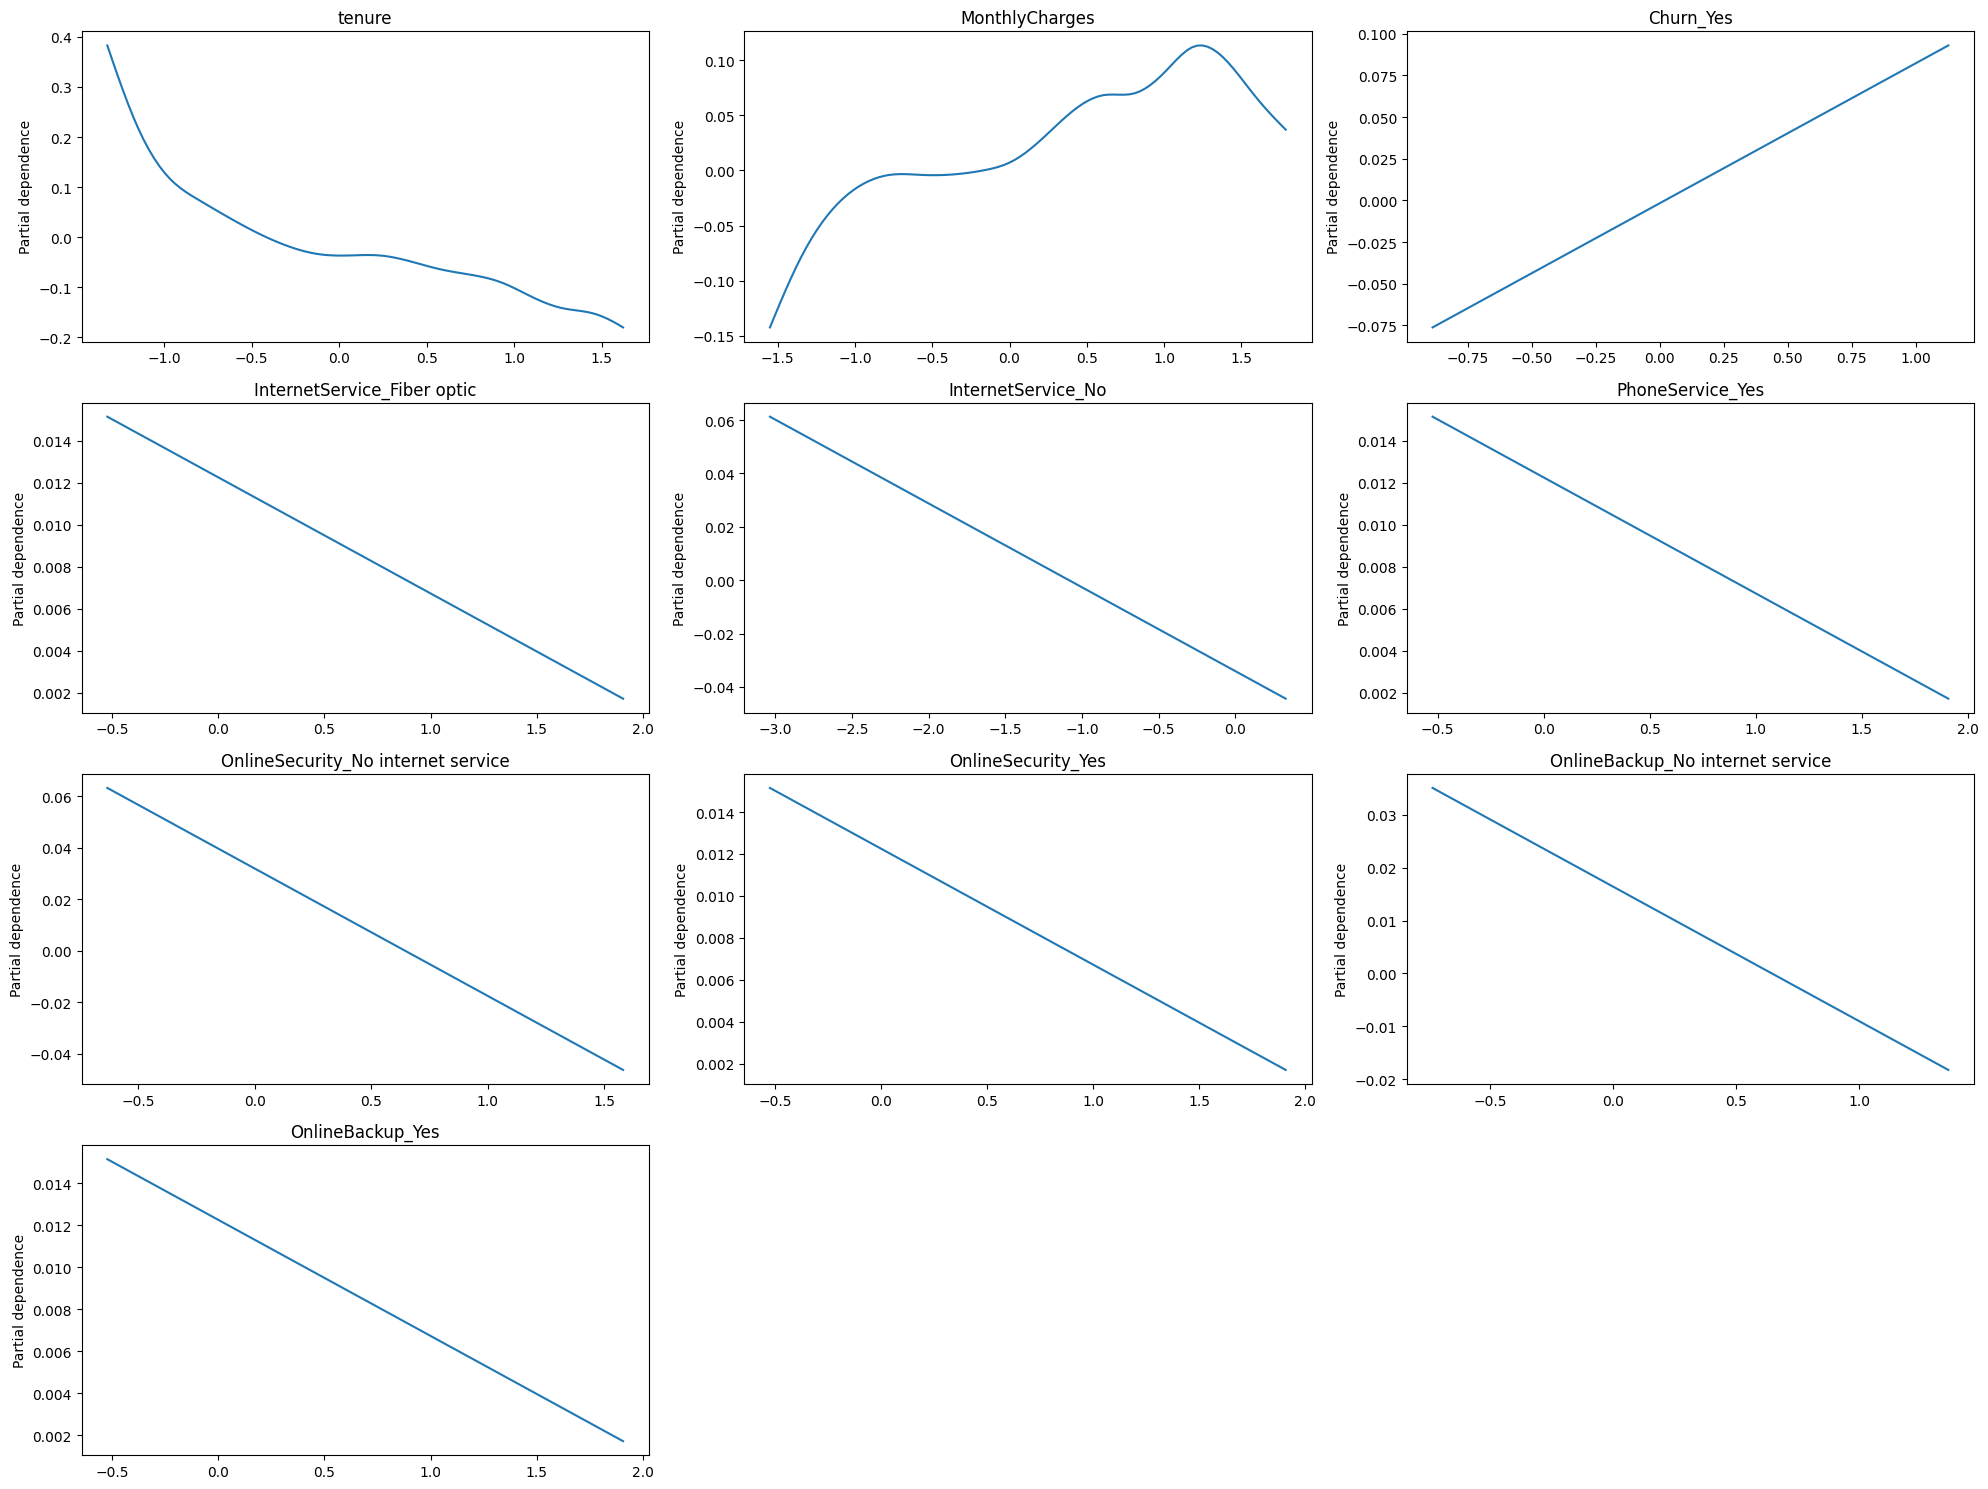

In [16]:
# Visualize GAM with Partial Independence plots
plt.figure(figsize=(20, 15))
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    plt.subplot(4, 3, i+1)
    XX = gam.generate_X_grid(term=i)
    plt.plot(XX[:, term.feature], gam.partial_dependence(term=i, X=XX))
    plt.title(df_encoded.columns[i])
    plt.ylabel('Partial dependence')
plt.tight_layout()
plt.show()

## Conclusion

Between the GAM model and the Linear regression model, the models performed essentially the same with regards to the MSE and R squared error, indicating they were the same at generalizing and capturing more variance than the GAM model. Therefore the linear regression model woult be preferred as it's more interpretable.

Between the Linear regression model and the logistic regression model, the purpose of what is trying to be done is classify whether a customer will churn or not, based on different parameters, which is exactly the purpose of the logistic regression model as it's used for classification. **Therefore in this case, the logistic regression model is the most useful to this company as it's inherently interpretable and accomplishes the task that the company wants to accomplish.**